In [9]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)




In [10]:
# try to parse the dates right at the beginning 
# it works out of the box if the date was stored ISO YYYY-MM-DD format

df_analyse=pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True).head()

,date,Italy,US,Spain,Germany,"Korea, South"
0,2020-01-22,0,1,0,0,1
1,2020-01-23,0,1,0,0,1
2,2020-01-24,0,2,0,0,2
3,2020-01-25,0,2,0,0,2
4,2020-01-26,0,5,0,0,3


In [11]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])


# Simulative approach to calculate SIR curves

In [12]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'
def simulate_SIR(country='Germany'):
    N0=1000000 #max susceptible population
    beta=0.4   # infection spread dynamics
    gamma=0.1  # recovery rate


    # condition I0+S0+R0=N0
    I0=df_analyse[country][35]
    S0=N0-I0
    R0=0
    SIR=np.array([S0,I0,R0])
    propagation_rates_sumulation=pd.DataFrame(columns={'susceptible':S0,
                                            'infected':I0,
                                            'recoverd':R0})



    for each_t in np.arange(100):

        new_delta_vec=SIR_model(SIR,beta,gamma)

        SIR=SIR+new_delta_vec

        propagation_rates_sumulation=propagation_rates_sumulation.append({'susceptible':SIR[0],
                                                    'infected':SIR[1],
                                                    'recovered':SIR[2]}, ignore_index=True)


    fig, ax1 = plt.subplots(1, 1)

    ax1.plot(propagation_rates_sumulation.index,propagation_rates_sumulation.infected,label='infected',color='k')
    ax1.plot(propagation_rates_sumulation.index,propagation_rates_sumulation.recovered,label='recovered')
    ax1.plot(propagation_rates_sumulation.index,propagation_rates_sumulation.susceptible,label='susceptible')

    ax1.set_ylim(10, 1000000)
    ax1.set_yscale('linear')
    ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
    ax1.set_xlabel('time in days',size=16)
    ax1.legend(loc='best',
               prop={'size': 16});

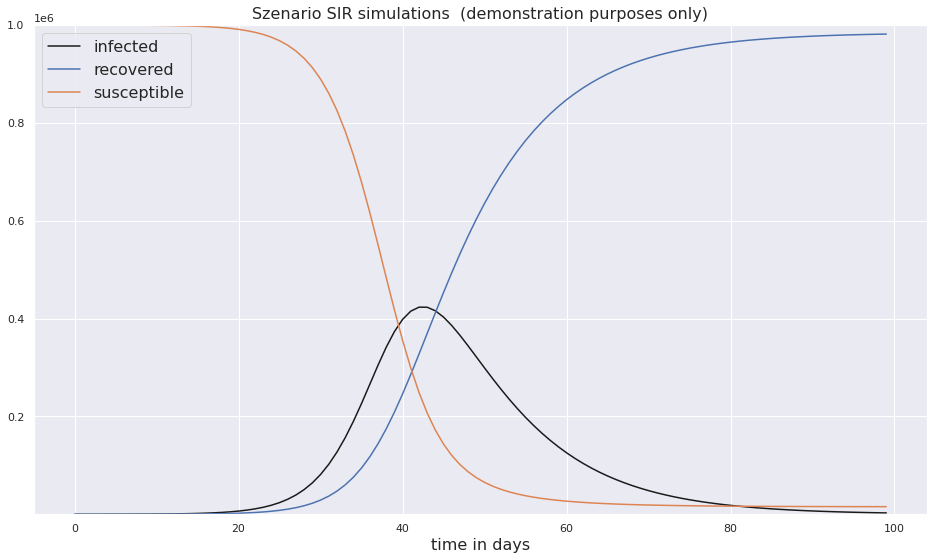

In [13]:
simulate_SIR()

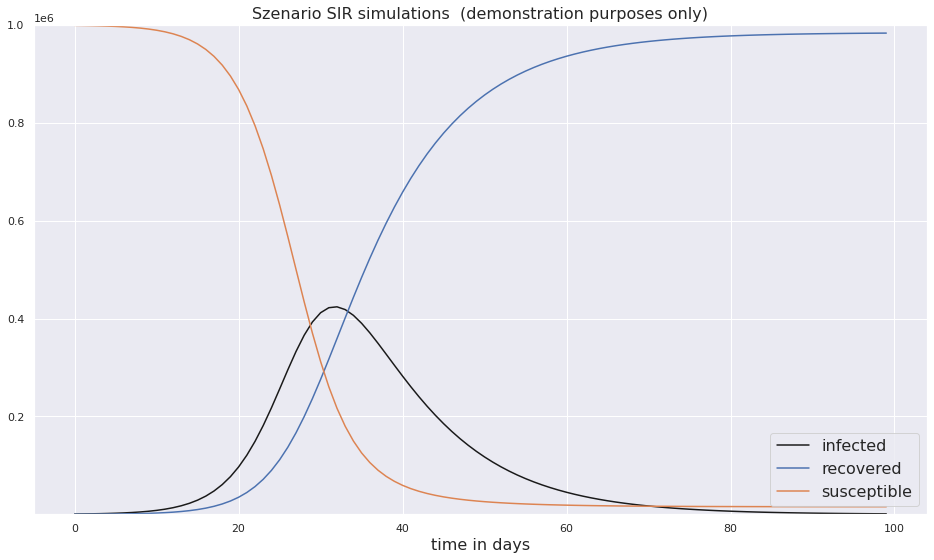

In [14]:
simulate_SIR('Italy')

# Fitting the parameters of SIR model

/home/vikas/anaconda3/envs/ds/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [0.00682684 0.00613471]  start infect: 27
Optimal parameters: beta = 0.41715861804629045  and gamma =  0.20293328515306866


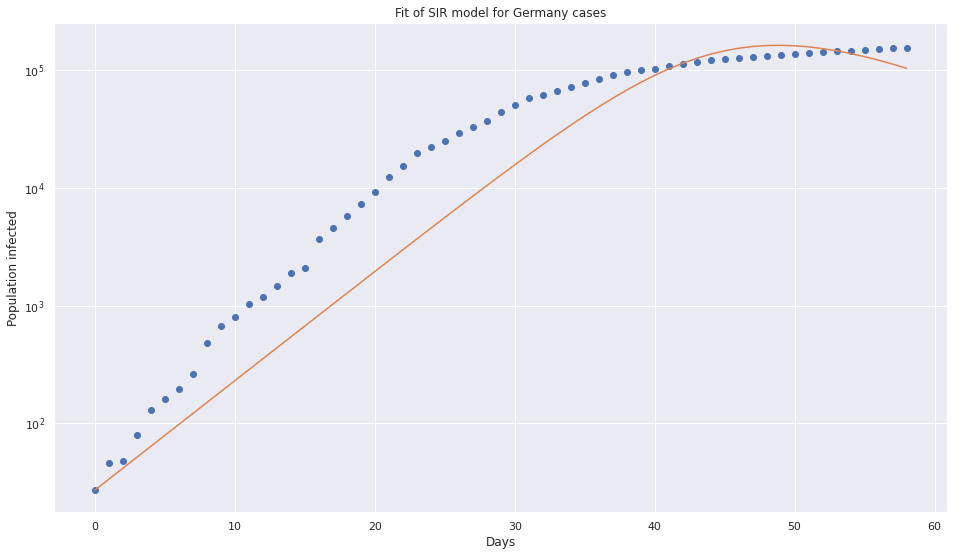

Optimal parameters: beta = 0.41715861804629045  and gamma =  0.20293328515306866
Basic Reproduction Number R0  2.055644138080334
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single \ infection in a population where all subjects are susceptible. @wiki


In [28]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI


# ensure re-initialization 
ydata = np.array(df_analyse.Germany[35:])
t=np.arange(len(ydata))
I0=ydata[0]
S0=N0-I0
R0=0
beta=0.4 

popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])


fitted=fit_odeint(t, *popt)

plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single \ infection in a population where all subjects are susceptible. @wiki")

# Dynamic beta in SIR (infection rate)

In [21]:
def dynamic_beta_SIR(country='Germany'):
    t_initial=28
    t_intro_measures=14
    t_hold=21
    t_relax=21

    ydata = np.array(df_analyse[country][35:])
    I0=ydata[0]
    N0=1000000
    S0=N0-I0
    R0=0

    beta_max=0.4
    beta_min=0.11
    gamma=0.1
    pd_beta=np.concatenate((np.array(t_initial*[beta_max]),
                           np.linspace(beta_max,beta_min,t_intro_measures),
                           np.array(t_hold*[beta_min]),
                            np.linspace(beta_min,beta_max,t_relax),
                           ))

    SIR=np.array([S0,I0,R0])
    propagation_rates_dynamic=pd.DataFrame(columns={'susceptible':S0,
                                            'infected':I0,
                                            'recoverd':R0})



    for each_beta in pd_beta:

        new_delta_vec=SIR_model(SIR,each_beta,gamma)

        SIR=SIR+new_delta_vec

        propagation_rates_dynamic=propagation_rates_dynamic.append({'susceptible':SIR[0],
                                                    'infected':SIR[1],
                                                    'recovered':SIR[2]}, ignore_index=True)

    fig, ax1 = plt.subplots(1, 1)

    ax1.plot(propagation_rates_dynamic.index,propagation_rates_dynamic.infected,label='infected',linewidth=3)

    t_phases=np.array([t_initial,t_intro_measures,t_hold,t_relax]).cumsum()
    ax1.bar(np.arange(len(ydata)),ydata, width=0.8,label=' current infected Germany',color='r')
    ax1.axvspan(0,t_phases[0], facecolor='b', alpha=0.2,label='no measures')
    ax1.axvspan(t_phases[0],t_phases[1], facecolor='b', alpha=0.3,label='hard measures introduced')
    ax1.axvspan(t_phases[1],t_phases[2], facecolor='b', alpha=0.4,label='hold measures')
    ax1.axvspan(t_phases[2],t_phases[3], facecolor='b', alpha=0.5,label='relax measures')
    ax1.axvspan(t_phases[3],len(propagation_rates_dynamic.infected), facecolor='b', alpha=0.6,label='repead hard measures')

    ax1.set_ylim(10, 1.5*max(propagation_rates_dynamic.infected))
    ax1.set_yscale('log')
    ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
    ax1.set_xlabel('time in days',size=16)
    ax1.legend(loc='best',
               prop={'size': 16});


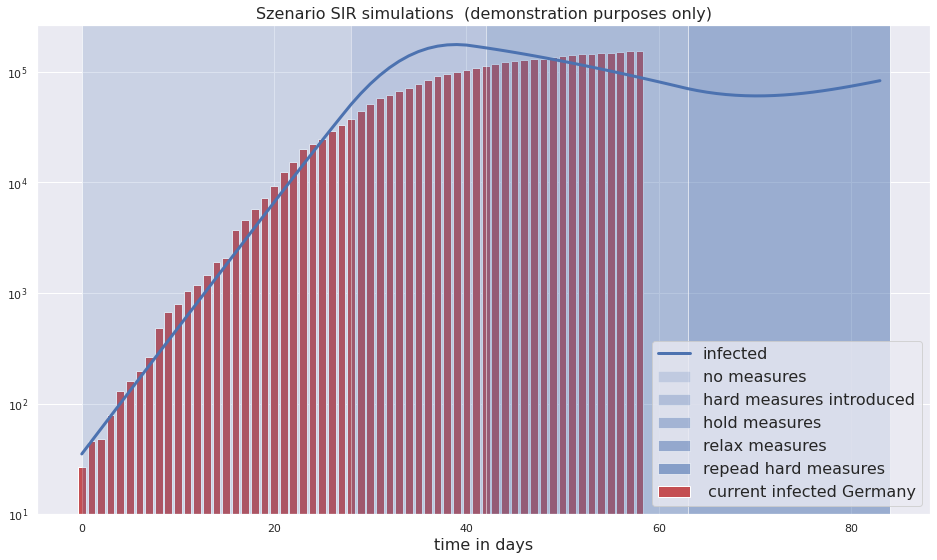

In [22]:
dynamic_beta_SIR()

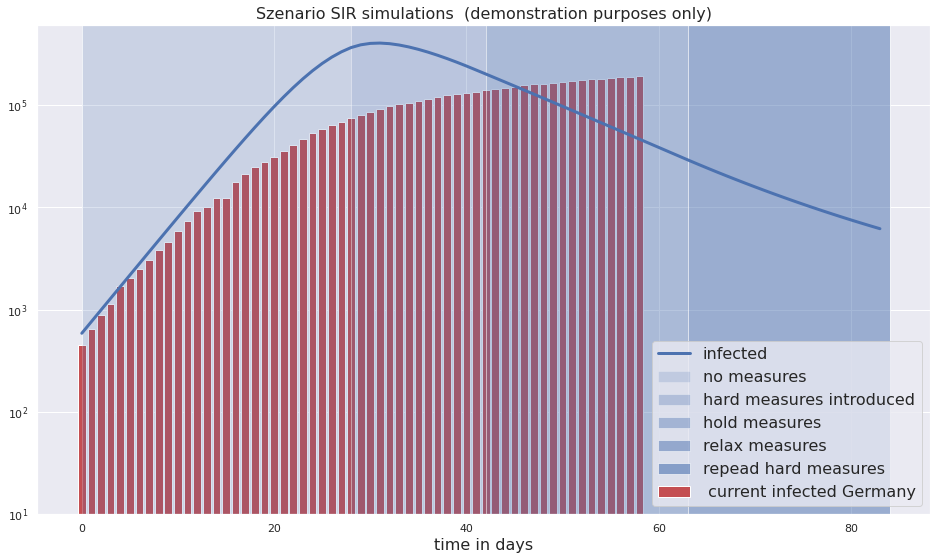

In [23]:
dynamic_beta_SIR('Italy')